In [1]:
import numpy as np #linear algebra
import pandas as pd
import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re

#Visulaization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set()

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91963\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91963\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91963\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Reading the csv file
bbc_text = pd.read_csv('data/bbc-text.csv')
print(bbc_text.shape)
bbc_text.head()

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
bbc_text = bbc_text.rename(columns = {'text' : 'News_headline'}, inplace=False)
bbc_text.head()

,category,News_headline
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
#Display all categories
bbc_text['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [5]:
bbc_text['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

Number of samples in each categroy


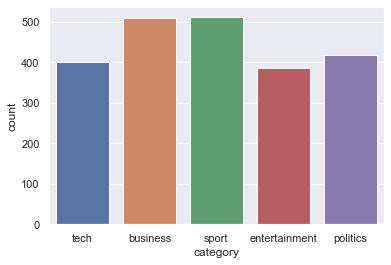

In [6]:
print("Number of samples in each categroy")
sns.countplot(bbc_text['category']);

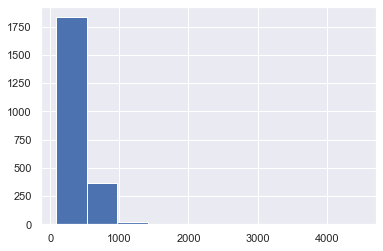

In [7]:
#Let's check range of words in dataset
def word_count(text):
    text.str.split().\
    map(lambda x: len(x)).\
    hist()

word_count(bbc_text['News_headline'])

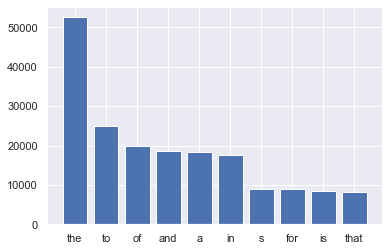

In [8]:
#Lets plot the frequencies of stop words
def plot_stopwords(data):
    stop = set(stopwords.words('english'))
    data_split = data.str.split()
    data_list = data_split.values.tolist()
    corpus = [word for i in data_list for word in i]
    from collections import defaultdict
    dictionary_stopwords = defaultdict(int)
    for word in corpus:
        if word in stop:
            dictionary_stopwords[word]+=1
            
    top=sorted(dictionary_stopwords.items(), key=lambda x:x[1], reverse=True)[:10]
    x,y = zip(*top)
    plt.bar(x,y)
    
plot_stopwords(bbc_text['News_headline'])

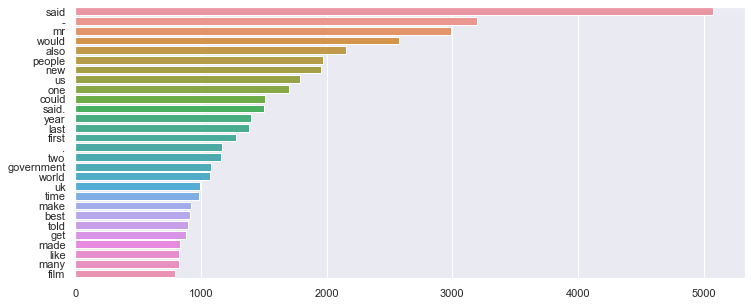

In [9]:
#Count of the most frequest occuring words
def top_freq_words(data):
    stop=set(stopwords.words('english'))
    data_split= data.str.split()
    data_list=data_split.values.tolist()
    corpus=[word for i in data_list for word in i]
    counter=Counter(corpus)
    mostCommon = counter.most_common()
    x,y=[], []
    for word,count in mostCommon[:100]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    ax,fig = plt.subplots(figsize=(12,5))
    sns.barplot(y,x)
    
top_freq_words(bbc_text['News_headline'])

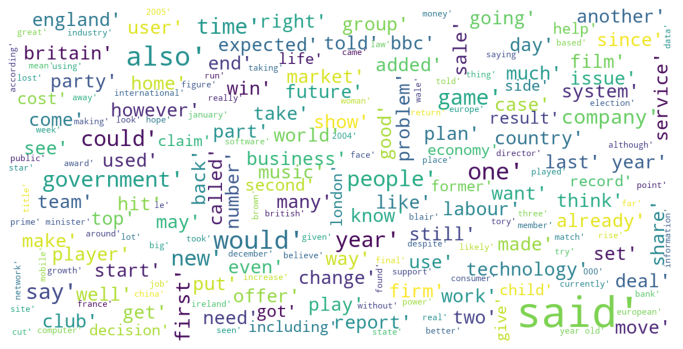

In [10]:
def plot_wordcloud(data):
    stop = set(stopwords.words('english'))
    def _preprocess_text(data):
        corpus = []
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
        for news in data:
            words = [w for w in word_tokenize(news) if (w not in stop)]
            
            words = [lem.lemmatize(w) for w in words if len(w)>2]
            
            corpus.append(words)
            
        return corpus
    
    corpus = _preprocess_text(data)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=200,
        max_font_size=25,
        scale=3,
        random_state=1)
    
    wordcloud = wordcloud.generate(str(corpus))
    
    fig = plt.figure(1, figsize=(12,12))
    plt.axis('off')
    
    plt.imshow(wordcloud)
    plt.show()
    
    
plot_wordcloud(bbc_text['News_headline'])

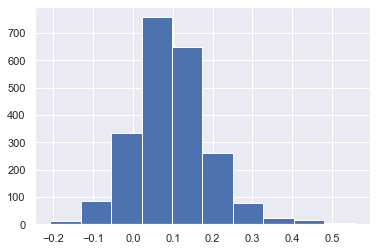

In [11]:
#Plot all headlines for positive, negative and neutral semantic

from textblob import TextBlob
def polarity_histo(data):
    
    def check_semantics(data):
        return TextBlob(data).sentiment.polarity
    
    polarity_val = data.apply(lambda a: check_semantics(a))
    
    polarity_val.hist()
    
polarity_histo(bbc_text['News_headline'])

In [12]:
# DATA CLEANING

def cleaning(bbc_text):
  if len(bbc_text)==1:
      word_tokens = word_tokenize(bbc_text)
  else:
      print('Wait! Data is getting cleaned...')
      # Tokenize : dividing Sentences into words
      bbc_text['text_clean'] = bbc_text['News_headline'].apply(nltk.word_tokenize)
      print('Step 1-Tokenization Done!.')
      print(bbc_text.head(5))
  
  # Remove stop words
  if len(bbc_text)==1:
      stop_words = set(stopwords.words('english')) 
      filtered_sentence = [w for w in word_tokens if not w in stop_words] 
      filtered_sentence = []   
      for w in word_tokens: 
          if w not in stop_words: 
              filtered_sentence.append(w)
  else:
      stop_words=set(nltk.corpus.stopwords.words("english"))
      bbc_text['text_clean'] = bbc_text['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
      print('Step 2-All stop words are removed from the list.')
      print(bbc_text.head(5))
  #Will keep words and remove numbers and special characters
  if len(bbc_text)!=1:
      regex = '[a-z]+'
      bbc_text['text_clean'] = bbc_text['text_clean'].apply(lambda x: [char for char in x if re.match(regex, char)])
      print('Step3-Numbers and Special Characters are removed.')
      print(bbc_text.head(5))

In [13]:
cleaning(bbc_text)

Wait! Data is getting cleaned...
Step 1-Tokenization Done!.
        category                                      News_headline  \
0           tech  tv future in the hands of viewers with home th...   
1       business  worldcom boss  left books alone  former worldc...   
2          sport  tigers wary of farrell  gamble  leicester say ...   
3          sport  yeading face newcastle in fa cup premiership s...   
4  entertainment  ocean s twelve raids box office ocean s twelve...   

                                          text_clean  
0  [tv, future, in, the, hands, of, viewers, with...  
1  [worldcom, boss, left, books, alone, former, w...  
2  [tigers, wary, of, farrell, gamble, leicester,...  
3  [yeading, face, newcastle, in, fa, cup, premie...  
4  [ocean, s, twelve, raids, box, office, ocean, ...  
Step 2-All stop words are removed from the list.
        category                                      News_headline  \
0           tech  tv future in the hands of viewers with home t

In [14]:
bbc_text['text_clean'] = bbc_text['text_clean'].apply(lambda x: ' '.join(x))

In [15]:
#assigning numbers to unique catergories
bbc_text.category = bbc_text.category.map({'tech':0,'business':1,'sport':2,'entertainment':3,'politics':4})
bbc_text['category'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [16]:
bbc_text.isnull().sum()

category         0
News_headline    0
text_clean       0
dtype: int64

In [17]:
#Lets split the data in feature and target
X = bbc_text.text_clean
y = bbc_text.category

In [19]:
vectorizer = CountVectorizer(stop_words = 'english',lowercase=False)

X_transformed = vectorizer.fit_transform(X).toarray()

In [20]:
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [66]:
#train-test split
X_train,X_test,y_train,y_test = train_test_split(X_transformed,y,train_size=0.6,random_state=1)

In [198]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1335, 27659), (890, 27659), (1335,), (890,))

In [185]:
#creating a function to fit, predict the model and print performance metrics
def model_fit_score(modelname):
    
    model = modelname()
    model.fit(X_train,y_train)
    
    y_preds = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    
    print(f'Accuracy score : {round(accuracy_score(y_test,y_preds)*100,2)}%')
    print('\n')
    print('Confusion Matrix : ')
    print(confusion_matrix(y_test,y_preds))
    print('\n')
    print('Classification Report')
    print(classification_report(y_test,y_preds))
    
    return model, y_preds, y_pred_prob
    

In [181]:
def plot_predictions(y_test=y_test, y_pred_prob=y_pred_prob):

    relabel = {'0': 'tech', '1': 'business', '2': 'sport', '3': 'entertainment', '4': 'politics'}
    fig, axs = plt.subplots(2, 2, figsize=(12,8))

    a = random.randint(0, len(y_test))
    actual_category = relabel[str(y_test.iloc[a])]
    predicted_category = relabel[str(np.argmax(y_pred_prob[a]))]
    sns.barplot(x=['tech', 'business', 'sport', 'entertainment', 'politics'], y=y_pred_prob[a], ax=axs[0, 0])
    axs[0, 0].set_title(f"Actual={actual_category}, Predicted={predicted_category+'-'+str(round(y_pred_prob[a].max()*100,2))}%")

    b = random.randint(0, len(y_test))
    actual_category = relabel[str(y_test.iloc[b])]
    predicted_category = relabel[str(np.argmax(y_pred_prob[b]))]
    sns.barplot(x=['tech', 'business', 'sport', 'entertainment', 'politics'], y=y_pred_prob[b], ax=axs[0, 1])
    axs[0, 1].set_title(f"Actual={actual_category}, Predicted={predicted_category+'-'+str(round(y_pred_prob[b].max()*100,2))}%")

    c = random.randint(0, len(y_test))
    actual_category = relabel[str(y_test.iloc[c])]
    predicted_category = relabel[str(np.argmax(y_pred_prob[c]))]
    sns.barplot(x=['tech', 'business', 'sport', 'entertainment', 'politics'], y=y_pred_prob[c], ax=axs[1, 0])
    axs[1, 0].set_title(f"Actual={actual_category}, Predicted={predicted_category+'-'+str(round(y_pred_prob[c].max()*100,2))}%")

    d = random.randint(0, len(y_test))
    actual_category = relabel[str(y_test.iloc[d])]
    predicted_category = relabel[str(np.argmax(y_pred_prob[d]))]
    sns.barplot(x=['tech', 'business', 'sport', 'entertainment', 'politics'], y=y_pred_prob[d], ax=axs[1, 1])
    axs[1, 1].set_title(f"Actual={actual_category}, Predicted={predicted_category+'-'+str(round(y_pred_prob[d].max()*100,2))}%")

    plt.show()   

## Logistics Regression 

In [189]:
lr_model, y_preds, y_pred_prob = model_fit_score(LogisticRegression)

Accuracy score : 97.53%


Confusion Matrix : 
[[151   2   1   1   0]
 [  0 206   0   2   2]
 [  0   2 194   0   1]
 [  1   2   1 154   1]
 [  1   2   3   0 163]]


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       155
           1       0.96      0.98      0.97       210
           2       0.97      0.98      0.98       197
           3       0.98      0.97      0.97       159
           4       0.98      0.96      0.97       169

    accuracy                           0.98       890
   macro avg       0.98      0.97      0.98       890
weighted avg       0.98      0.98      0.98       890



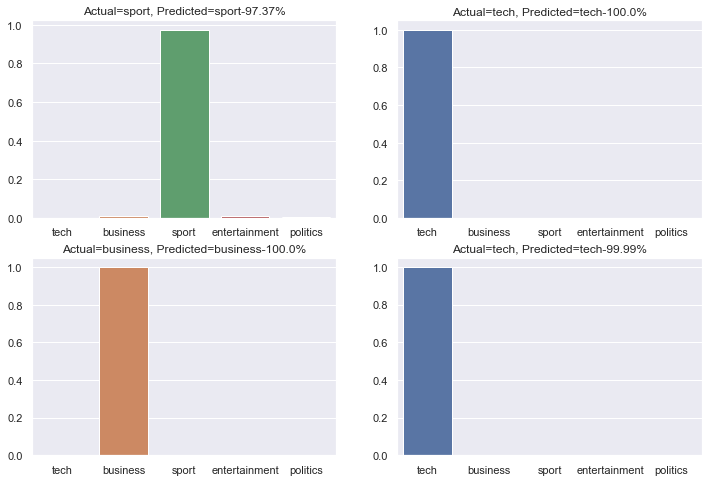

In [190]:
plot_predictions(y_test=y_test, y_pred_prob=y_pred_prob)

## Naive Baye's MultinominalNB

In [191]:
mnbmodel, y_preds, y_pred_prob = model_fit_score(MultinomialNB)

Accuracy score : 98.09%


Confusion Matrix : 
[[153   0   1   0   1]
 [  1 204   0   0   5]
 [  0   1 194   1   1]
 [  0   1   0 157   1]
 [  1   2   0   1 165]]


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       155
           1       0.98      0.97      0.98       210
           2       0.99      0.98      0.99       197
           3       0.99      0.99      0.99       159
           4       0.95      0.98      0.96       169

    accuracy                           0.98       890
   macro avg       0.98      0.98      0.98       890
weighted avg       0.98      0.98      0.98       890



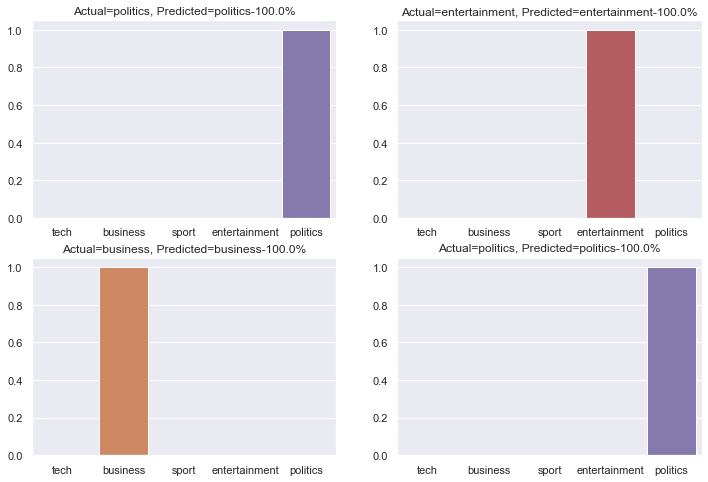

In [192]:
plot_predictions(y_test=y_test, y_pred_prob=y_pred_prob)

## Saving the model

In [194]:
# save the model to a file using pickle
with open('mnbmodel.pkl', 'wb') as file:
    pickle.dump(mnbmodel, file)